#**Assignment 7 - NLP** | María Daniela Baptista Theuerkauf

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.

In [2]:
from datasets import load_dataset
import pandas as pd
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from nltk import bigrams
from collections import Counter


In [3]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
# Load the emotion dataset
dataset = load_dataset("emotion",trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [5]:
print(dataset)
print(dataset['train'][0])
print(dataset['train'][1])
print(dataset['train'][2])

# labels: sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})
{'text': 'i didnt feel humiliated', 'label': 0}
{'text': 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'label': 0}
{'text': 'im grabbing a minute to post i feel greedy wrong', 'label': 3}


In [6]:
# Preprocessing function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    emoticon_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        "]+", flags=re.UNICODE)  # Remove emoticons
    text = emoticon_pattern.sub(r'', text)
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and special characters
    text = re.sub(r'\d+', '', text)  # Remove digits
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatize
    return ' '.join(tokens)

# Apply preprocessing to the dataset
dataset = dataset.map(lambda x: {'text': preprocess_text(x['text'])})

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [7]:
#checking the changes
print(dataset['train'][0])
print(dataset['train'][1])

# labels: sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5)

{'text': 'didnt feel humiliated', 'label': 0}
{'text': 'go feeling hopeless damned hopeful around someone care awake', 'label': 0}


In [8]:
# Statistics
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])

train_tokens = df_train['text'].apply(word_tokenize)
test_tokens = df_test['text'].apply(word_tokenize)

train_unigrams = Counter([token for sublist in train_tokens for token in sublist])
test_unigrams = Counter([token for sublist in test_tokens for token in sublist])

train_bigrams = Counter([bigram for sublist in train_tokens for bigram in bigrams(sublist)])
test_bigrams = Counter([bigram for sublist in test_tokens for bigram in bigrams(sublist)])

# Basic statistics
train_text_lengths = train_tokens.apply(len)
test_text_lengths = test_tokens.apply(len)

# Print some basic statistics
print(f"Number of training samples: {len(df_train)}")
print(f"Number of test samples: {len(df_test)}")
print("Label distribution in training set:")
print(df_train['label'].value_counts())
print("Label distribution in test set:")
print(df_test['label'].value_counts())
print(f"Total number of tokens in training set: {sum(train_unigrams.values())}")
print(f"Total number of tokens in test set: {sum(test_unigrams.values())}")
print("Most common unigrams in training set:")
print(train_unigrams.most_common(10))
print("Most common unigrams in test set:")
print(test_unigrams.most_common(10))
print("Most common bigrams in training set:")
print(train_bigrams.most_common(10))
print("Most common bigrams in test set:")
print(test_bigrams.most_common(10))

Number of training samples: 16000
Number of test samples: 2000
Label distribution in training set:
label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64
Label distribution in test set:
label
1    695
0    581
3    275
4    224
2    159
5     66
Name: count, dtype: int64
Total number of tokens in training set: 149629
Total number of tokens in test set: 18605
Most common unigrams in training set:
[('feel', 11506), ('feeling', 5455), ('like', 2918), ('im', 2430), ('time', 974), ('really', 942), ('know', 872), ('get', 778), ('make', 769), ('little', 736)]
Most common unigrams in test set:
[('feel', 1441), ('feeling', 688), ('like', 374), ('im', 310), ('really', 118), ('time', 116), ('know', 105), ('get', 103), ('people', 99), ('little', 95)]
Most common bigrams in training set:
[(('feel', 'like'), 1838), (('im', 'feeling'), 885), (('make', 'feel'), 296), (('feeling', 'little'), 206), (('like', 'im'), 191), (('still', 'feel'), 181), (('feel', 'little'),

Multinomial Naive Bayes Accuracy on Test Set: 0.70
Multinomial Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.93      0.79       581
           1       0.66      0.99      0.79       695
           2       1.00      0.06      0.12       159
           3       0.94      0.34      0.50       275
           4       0.91      0.30      0.45       224
           5       0.00      0.00      0.00        66

    accuracy                           0.70      2000
   macro avg       0.70      0.44      0.44      2000
weighted avg       0.74      0.70      0.63      2000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 800x600 with 0 Axes>

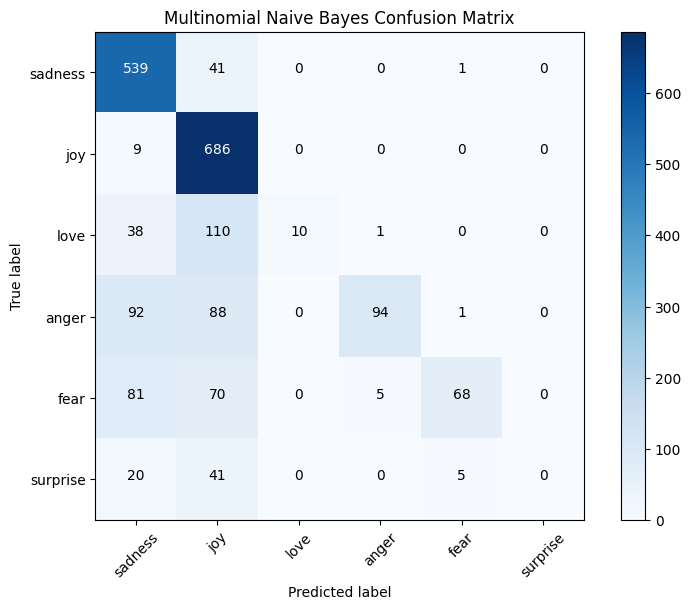

In [9]:
# Traditional model - Multinomial Naive Bayes
X_train = df_train['text']
X_test = df_test['text']
y_train = df_train['label']
y_test = df_test['label']

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)
y_pred_nb = nb_classifier.predict(X_test_tfidf)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f'Multinomial Naive Bayes Accuracy on Test Set: {accuracy_nb:.2f}')
print("Multinomial Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))
conf_mat_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(8, 6))

# Confusion matrix plot for Multinomial Naive Bayes
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat_nb, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Multinomial Naive Bayes Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, dataset['train'].features['label'].names, rotation=45)
plt.yticks(tick_marks, dataset['train'].features['label'].names)

# Add numerical values to the plot
thresh = conf_mat_nb.max() / 2.
for i in range(conf_mat_nb.shape[0]):
    for j in range(conf_mat_nb.shape[1]):
        plt.text(j, i, format(conf_mat_nb[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_mat_nb[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


Epoch 1/10
400/400 [==============================] - 11s 24ms/step - loss: 0.7678 - accuracy: 0.7329 - val_loss: 0.4072 - val_accuracy: 0.8659
Epoch 2/10
400/400 [==============================] - 9s 23ms/step - loss: 0.1098 - accuracy: 0.9634 - val_loss: 0.4628 - val_accuracy: 0.8578
Epoch 3/10
400/400 [==============================] - 10s 24ms/step - loss: 0.0363 - accuracy: 0.9878 - val_loss: 0.4933 - val_accuracy: 0.8622
Epoch 4/10
400/400 [==============================] - 8s 19ms/step - loss: 0.0197 - accuracy: 0.9940 - val_loss: 0.5255 - val_accuracy: 0.8603
Epoch 5/10
400/400 [==============================] - 9s 23ms/step - loss: 0.0143 - accuracy: 0.9955 - val_loss: 0.5676 - val_accuracy: 0.8603
Epoch 6/10
400/400 [==============================] - 8s 21ms/step - loss: 0.0115 - accuracy: 0.9959 - val_loss: 0.6056 - val_accuracy: 0.8594
Epoch 7/10
400/400 [==============================] - 10s 25ms/step - loss: 0.0097 - accuracy: 0.9965 - val_loss: 0.6392 - val_accuracy: 0.8

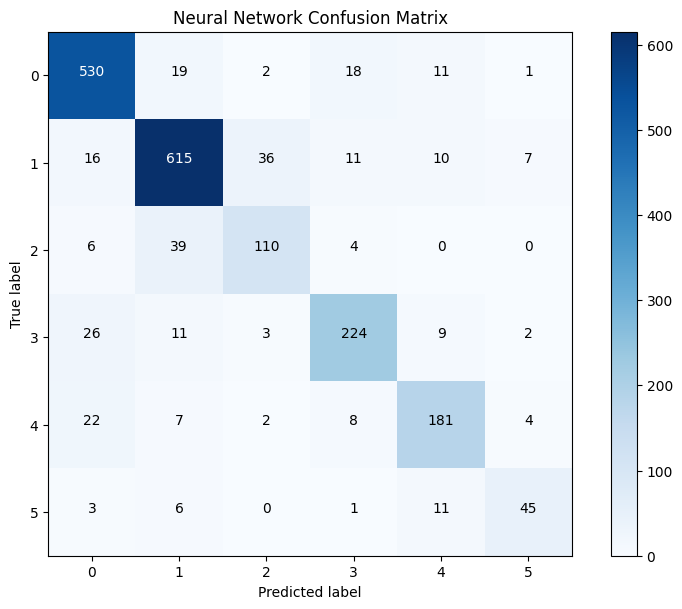

In [11]:
# Neural Network model
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_tokenized = tokenizer.texts_to_matrix(X_train, mode='tfidf')
X_test_tokenized = tokenizer.texts_to_matrix(X_test, mode='tfidf')

# Number of classes (emotions)
num_classes = 6

# Sequential model
model = Sequential([
    Dense(80, input_shape=(X_train_tokenized.shape[1],), activation='relu'),
    Dense(30, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_tokenized, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, accuracy_nn = model.evaluate(X_test_tokenized, y_test)
print(f'Neural Network Accuracy on Test Set: {accuracy_nn:.2f}')

# Predictions
y_pred_nn = np.argmax(model.predict(X_test_tokenized), axis=-1)
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn))

# Confusion matrix
conf_mat_nn = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat_nn, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Neural Network Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test))
plt.yticks(tick_marks, np.unique(y_test))

# Adding numerical values to the plot
thresh = conf_mat_nn.max() / 2.
for i in range(conf_mat_nn.shape[0]):
    for j in range(conf_mat_nn.shape[1]):
        plt.text(j, i, format(conf_mat_nn[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_mat_nn[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
